In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [3]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

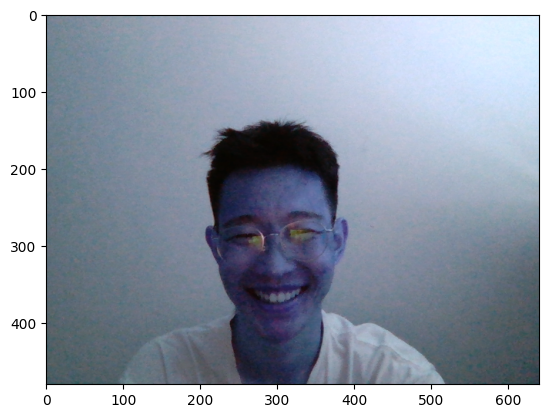

In [12]:
plt.imshow(tf.cast(np.squeeze(img), dtype=tf.int32))

In [10]:
img = frame.copy()

In [13]:
img.shape

(480, 640, 3)

In [7]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3]),
  'shape_signature': array([ 1,  1, 17,  3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [24]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    print(keypoints_with_scores)

    # Rendering 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)

    cv2.imshow('MoveNet Lightning', frame)

    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[[[[ 0.580881    0.39175662  0.6189547 ]
   [ 0.5370425   0.43064126  0.7643744 ]
   [ 0.53554755  0.3494353   0.7160546 ]
   [ 0.543939    0.47757274  0.39698148]
   [ 0.5408022   0.2878582   0.6342503 ]
   [ 0.7259049   0.5838195   0.8193729 ]
   [ 0.7547796   0.18293884  0.6529466 ]
   [ 0.86831725  0.6812884   0.01525015]
   [ 0.9754447   0.0827985   0.06542766]
   [ 0.8548684   0.55057544  0.00688028]
   [ 0.8540064   0.29293892  0.00598165]
   [ 1.0195528   0.5099032   0.0114848 ]
   [ 1.0207691   0.23216633  0.00593042]
   [ 0.7287468   0.6052021   0.01993653]
   [ 0.79166234  0.16574922  0.00939825]
   [ 0.8699493   0.58366245  0.00109118]
   [ 0.9030385  -0.0010993   0.00816461]]]]
[[[[0.56687826 0.39296645 0.58043766]
   [0.5204551  0.4326461  0.58995485]
   [0.51840806 0.35097253 0.6117432 ]
   [0.53043866 0.48152834 0.60592055]
   [0.5305029  0.29351518 0.6603785 ]
   [0.72153443 0.5911     0.81644535]
   [0.75373554 0.18135029 0.6940907 ]
   [0.9368617  0.7325164  0.026092

In [14]:
right_eye = keypoints_with_scores[0][0][2]
left_elbow = keypoints_with_scores[0][0][7]

In [15]:
shaped = np.squeeze(np.multiply(interpreter.get_tensor(interpreter.get_output_details()[0]['index']), [480,640,1]))

In [16]:
for kp in shaped:
    ky, kx, kp_conf = kp
    print(int(ky), int(kx), kp_conf)

298 295 0.4253998398780823
269 333 0.4810679852962494
274 259 0.7664240598678589
284 374 0.6571831107139587
293 223 0.7496867775917053
394 451 0.6319794654846191
389 152 0.7599464654922485
454 515 0.02437913417816162
459 116 0.02723643183708191
398 368 0.014617234468460083
407 265 0.019548743963241577
174 312 0.0134773850440979
188 229 0.028055310249328613
417 491 0.012674331665039062
391 157 0.026153206825256348
476 16 0.015409648418426514
425 9 0.016130447387695312


In [17]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [22]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [19]:
shaped[0], shaped[1]

(array([298.07092667, 295.55257797,   0.42539984]),
 array([269.18761253, 333.86413574,   0.48106799]))

In [20]:
for edge, color in EDGES.items():
    p1, p2 = edge
    y1, x1, c1 = shaped[p1]
    y2, x2, c2 = shaped[p2]
    print((int(x2), int(y2)))

(333, 269)
(259, 274)
(374, 284)
(223, 293)
(451, 394)
(152, 389)
(515, 454)
(368, 398)
(116, 459)
(265, 407)
(152, 389)
(312, 174)
(229, 188)
(229, 188)
(491, 417)
(16, 476)
(157, 391)
(9, 425)


In [21]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)